<a href="https://colab.research.google.com/github/CesarRoaldes/satellite_imagery/blob/master/Camembert_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT classification model 

In [2]:
import spacy 
import numpy as np 
import pandas as pd 
import os 
os.getcwd()
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### Set up Colab GPU 

In [3]:
# First you should go in 'Edit' -> 'Notebook settings' -> Add device GPU
import tensorflow as tf

# GPU device name.
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

Let's now tell torch that one GPU is available 

In [4]:
import torch

if torch.cuda.is_available():  
        
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


Let's install the Hugging Face Library transformer package 

In [5]:
! pip install transformers 

     |████████████████████████████████| 542kB 2.7MB/s 
     |████████████████████████████████| 1.0MB 8.8MB/s 
     |████████████████████████████████| 870kB 18.0MB/s 
     |████████████████████████████████| 3.7MB 20.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=72f95e283adfea8987687976a57b25e4ca114d7743e61219f88e3a42cadd62e4
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


### Loading our corpus and preprocessing 

In [0]:
import pandas as pd
# Import medium_df_desq in "files"
# Load the dataset into a pandas dataframe.
df=pd.read_csv('medium_df_deseq.csv',encoding='utf-8')

# We replace the labels in a more normalized way : 0=men, 1=women 
df.sexe=df.sexe.replace(1,0)
df.sexe=df.sexe.replace(2,1)

1. Unbalanced sample 


In [0]:

#Shuffle the data 
df=df.sample(frac=1).reset_index()

# Reduce to the variables we are interested in 
df=df[['Texte','sexe']]

# Report the number of speeches in the corpus.
print('Number of text in this corpus : {:,}\n'.format(df.shape[0]))

df.head(5)

2. Balanced sample

In [22]:
# Let's take a balanced sample (model classifying all in men otherwise)
df_m = df.loc[df['sexe'] == 0]
df_f = df.loc[df['sexe'] == 1] 
df_m = df_m[0:len(df_f)]
df = df_f.append(df_m)

#Shuffle the data 
df=df.sample(frac=1).reset_index()

# Reduce to the variables we are interested in 
df=df[['Texte','sexe']]

# Report the number of speeches in the corpus.
print('Number of text in this corpus : {:,}\n'.format(df.shape[0]))

df.head(5)

Number of text in this corpus : 2,500



,Texte,sexe
0,"Mesdames, Messieurs,Après avoir salué une nouv...",0
1,M. le président. L'ordre du jour appelle le dé...,0
2,"Madame et messieurs les ministres,Mesdames, me...",1
3,M. le président. L'ordre du jour appelle le dé...,1
4,"Monsieur le maire, mon cher Gilbert,Monsieur ...",0


3. Spliting texts in order to feed the model with all parts 

In [0]:
split_text=[]
for text in df.Texte[0:1]:
  token_text= text.split(' ')
  for i in range(0,len(token_text),500):
    split_text = split_text +[j for j in token_text[i:i+500]]

In [44]:
split_text

['Messieurs,Je',
 'suis',
 'heureux',
 'de',
 'vous',
 'saluer.',
 'Quand',
 'je',
 'dis',
 'que',
 'je',
 'suis',
 'heureux',
 'de',
 'vous',
 'saluer,',
 'ce',
 "n'est",
 'pas',
 'une',
 'simple',
 'affirmation',
 'de',
 'politesse.',
 'Je',
 'le',
 'disais',
 'à',
 "l'instant",
 'à',
 'Monsieur',
 'le',
 'Ministre',
 'de',
 'la',
 'Défense,',
 'M.',
 'Richard,',
 "c'est",
 'pour',
 'moi',
 'un',
 'instant',
 'où',
 'il',
 'y',
 'a',
 'un',
 'peu',
 "d'émotion;",
 'je',
 'vais',
 'vous',
 'dire',
 'pourquoi.Vous',
 'êtes',
 'la',
 'première',
 'classe',
 "d'âge",
 'qui',
 'ne',
 'fera',
 'pas',
 'de',
 'service',
 'militaire.',
 "C'est",
 'une',
 'décision',
 'que',
 "j'ai",
 'prise,',
 'il',
 'y',
 'a',
 'deux',
 'ans,',
 'après',
 'une',
 'vraie',
 'réflexion',
 'et',
 'un',
 'vrai',
 'débat.',
 'Après',
 'tout,',
 'le',
 'service',
 'militaire',
 "c'est",
 'une',
 'vieille',
 'tradition',
 'nationale,',
 'il',
 'était',
 'plus',
 'que',
 'centenaire.',
 'Il',
 'y',
 'avait',
 'tou

In [0]:
token_text= tokenizer.tokenize(df.Texte[0])

In [0]:
split_text=[]
for i in range(0,len(token_text),500):
      split_text.append([token_text[i:i+500]])

In [36]:
for i in range(len(token_text)):
      A=[token_text[i:i+500]

SyntaxError: ignored

In [0]:
# Let's take a balanced sample (model classifying all in men otherwise)
df_m = df.loc[df['sexe'] == 0]
df_f = df.loc[df['sexe'] == 1] 
df_m = df_m[0:len(df_f)]
df = df_f.append(df_m)

#Shuffle the data 
df=df.sample(frac=1).reset_index()

# Reduce to the variables we are interested in 
df=df[['Texte','sexe']]

# Report the number of speeches in the corpus.
print('Number of text in this corpus : {:,}\n'.format(df.shape[0]))

df.head(5)

In [0]:
# Display the first text 
#df.Texte[0]

#### Tokenization of our text and preparing to feed CamemBERT

#### Loading the Camembert Tokenizer

In [11]:
# Import Camembert tokenizer
from transformers import CamembertTokenizer
# We choose a right padding side for the moment and we will test for a left padding side on a second stage
tokenizer = CamembertTokenizer.from_pretrained('camembert-base', do_lower_case=False,padding_side='left') #right


In [0]:
# Print the original text.
print(' Original: ', df.Texte[0])

# Print the text split into tokens.
print('Tokenized: ', tokenizer.tokenize(df.Texte[0]))

# Print the text mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(df.Texte[0])))

 Original:  Mesdames et MessieursJ'ai souhaité être aujourd'hui présente à Roissy sur l'aéroport Charles de Gaulle, pour assister au travail des agents des douanes et des services vétérinaires dans la lutte contre le trafic d'espèces sauvages et témoigner, auprès d'eux, de la détermination du gouvernement français à lutter contre ce fléau.Le trafic de plantes ou d'animaux sauvages contribue en effet de façon tout à fait dramatique et, malheureusement parfois déterminante, à la disparition des espèces tout autour de la planète.De par la masse financière qu'il représente, ce trafic compte aujourd'hui parmi les plus importants dans le monde, avec la drogue et la contrefaçon.Nos concitoyens n'en ont pas suffisamment conscience, encore aujourd'hui.A l'heure des départs en vacances de Noël, à l'heure de la détente et du bonheur partagé en famille, parfois sous d'autres latitudes, je voulais rappeler que l'insouciance en la matière peut être, pour la nature, criminelle.Importer illégalement u

#### Adding special tokens to the start and end of the text


Preprocessing steps : 


1.   **Add special tokens [CLS] [SEP]** 

According to the documentation we need to add special tokens to the start and end of the text Moreover, for camembert we should add a space between CLS and the first token (not sure here, we have to ask benjamin). 

2.   **Pad and truncate all texts to a single number**

Pretrained transformes like Camembert only accept input of the same length. Our corpus contains large texts and we have to pad them in order to be able to feed Camembert. We will set the max length to a large number in order to get all information possible in the text. We choose a max length of 500 which is almost the maximum (512) "sentence" length  accepted. We are aware that this choice will impact a lot training speed.

3.   **Construct an attention mask**

Attention masks are just set to 1 when the token have to be analyzed and 0 otherwise (padded tokens). All our attention mask should be 1 with this corpus. 



For sake of simplicity and to avoid errors we will use the function encode_plus of the library which is really convenient. 



#### Length and attention mask 

In [0]:
texts = df.Texte.values
labels = df.sexe.values
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]
# Apply function to our corpus
for text in texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 500,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max (marche pas en pad left ?)
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                   )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
    input_ids.append(encoded_dict['input_ids'])
 
    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
    attention_masks.append(encoded_dict['attention_mask'])

In [0]:
# We convert all this into tensors in order to be able to make it work on GPU 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Original text and transformed tensor print 
print('Original: ', texts[0])
print('IDs:', input_ids[0])

Original:  Mesdames et MessieursJ'ai souhaité être aujourd'hui présente à Roissy sur l'aéroport Charles de Gaulle, pour assister au travail des agents des douanes et des services vétérinaires dans la lutte contre le trafic d'espèces sauvages et témoigner, auprès d'eux, de la détermination du gouvernement français à lutter contre ce fléau.Le trafic de plantes ou d'animaux sauvages contribue en effet de façon tout à fait dramatique et, malheureusement parfois déterminante, à la disparition des espèces tout autour de la planète.De par la masse financière qu'il représente, ce trafic compte aujourd'hui parmi les plus importants dans le monde, avec la drogue et la contrefaçon.Nos concitoyens n'en ont pas suffisamment conscience, encore aujourd'hui.A l'heure des départs en vacances de Noël, à l'heure de la détente et du bonheur partagé en famille, parfois sous d'autres latitudes, je voulais rappeler que l'insouciance en la matière peut être, pour la nature, criminelle.Importer illégalement un

In [0]:
labels

tensor([1, 1, 1,  ..., 1, 0, 0])

5 and 6 seem to be the [CLS] and [SEP] special tokens 


#### Train and validation dataset construction 


In [0]:
from torch.utils.data import TensorDataset, random_split

# Combine all above
dataset = TensorDataset(input_ids, attention_masks, labels)

# Let's create a 80-20 train / validation dataset 
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])

print('We have {} training samples'.format(train_size))
print('We have {} validation samples'.format(val_size))

We have 2000 training samples
We have 500 validation samples


In order to save on memory we use the convenient DataLoader of pytorch.utils 

In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# We set the size of the batch lower than what is usually set (16 of 32)
batch_size = 4

# We create data loaders for the train and validation dataset. 
train_dataloader = DataLoader(
            train_set,  # The training samples.
            sampler = RandomSampler(train_set), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

val_dataloader = DataLoader(
            val_set, # The validation samples.
            sampler = SequentialSampler(val_set), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

### CamemBERT Sequence Classification model tuning


#### Loading the model


We will finally build up our model. We will use the  CamemBERT model for sequence classification which includes a special top layer designed for this task. 

In [0]:
# Importing from transformers
from transformers import CamembertForSequenceClassification, CamembertConfig

In [0]:
# Loading the model
# Ici je ne suis pas sure pour le 'cased' ou pas (je crois que oui)
gender_model1 = CamembertForSequenceClassification.from_pretrained(
    "camembert-base", 
    num_labels = 2, # We have two different labels Women = 1 and Men =0   
    output_attentions = False, 
    output_hidden_states = False, 
)

In [0]:
# We run the model on the colab GPU 
gender_model1.cuda()

CamembertForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

Optimizers and Loss

We will choose the AdamW optimizer and set for this first model the learning rate and the epsilon to default. At the batch is little we might want to increase the learning rate a bit from what is usually used. 

In [0]:
import torch.nn as nn
import torch.optim as optim
from transformers import AdamW

criterion = nn.BCEWithLogitsLoss()
#Implements Adam algorithm with weight decay fix.
optimizer = AdamW(gender_model1.parameters(),
                  lr = 5e-5, # Adaptative (yes i think)
                  eps = 1e-8 # prevent division by 0 
                )

We fiw the number of epochs to 4
We also configure the learning rate 

In [0]:
from transformers import get_linear_schedule_with_warmup

# set number of epochs
epochs = 5
total_steps = len(train_dataloader) * epochs
# Create a schedule with a learning rate that decreases linearly after linearly increasing during a warmup period (0 here)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

### Constructing the training and validation loop 


In [0]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [0]:
from sklearn.metrics import confusion_matrix

In [0]:
# https://github.com/huggingface/transformers 
# https://github.com/chambliss/Multilingual_NER/blob/master/python/utils/main_utils.py#L404  

import random
# Let's put a seed to make this result reproducible 
seed=2020
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# We want to evaluate the training phase 
training_stats = []

for ep in range(0, epochs):
  print('===========Starting Epoch {} / {} =============='.format(ep+1,epochs))
  print('Training starts')

  

  ################################### TRAINING ################################

  # Set the train loss for the epoch to 0 
  total_train_loss = 0

  #Put the model in training 
  gender_model1.train()

  for step, batch in enumerate(train_dataloader):
    # Cpy the 3 batch to GPU 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    # Clear gradients 
    gender_model1.zero_grad() 
    
    #return loss and logits
    loss, logits = gender_model1(b_input_ids, 
                         token_type_ids=None, 
                         attention_mask=b_input_mask, 
                         labels=b_labels) 
    
    # Accumulate training loss for all batches 
    total_train_loss += loss.item()

    # Backward to calculate gradients 
    loss.backward()

    # Prevent exploding gradients problem 
    torch.nn.utils.clip_grad_norm_(gender_model1.parameters(), 1.0)

    # Update parameters 
    optimizer.step()

    # Update learning rate schedule
    scheduler.step()

  #Calculate the average training loss over all batches  
  avg_train_loss = total_train_loss / len(train_dataloader)
  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print('')
  print('And now, validation STARTS')

  ###################### VALIDATION #############################

  # Put model in evaluation mode 
  gender_model1.eval()

  # Set statistics to 0
  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0

  # Confusion matrix ?
  predictions, true_labels = [], []

  for batch in val_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
     
     # We don't care about gradients for eval
    with torch.no_grad(): 
      (loss, logits) = gender_model1(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
    total_eval_loss += loss.item()

      # Move logits and labels to CPU 
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Confusion matrix ?
    val_batch_preds = np.argmax(logits, axis=1)
    val_batch_labels = label_ids
    predictions.extend(val_batch_preds)
    true_labels.extend(val_batch_labels)



      # Accumulation accuracy for all batch
    total_eval_accuracy += flat_accuracy(logits, label_ids)
    
    #Final accuracy on all batch
  avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
  print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    #Final loss over all batch
  avg_val_loss = total_eval_loss / len(val_dataloader)
  print("  Validation Loss: {0:.2f}".format(avg_val_loss))

  # confusion matrix ? 
  pred_tags = [i for i in predictions]
  valid_tags = [i for i in true_labels]


  training_stats.append(
        {
            'epoch': ep + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
        }
    )

print("")
print("Done !")

===========Starting Epoch 1 / 5 ==============
Training starts

  Average training loss: 0.56

And now, validation STARTS
  Accuracy: 0.77
  Validation Loss: 0.64
===========Starting Epoch 2 / 5 ==============
Training starts

  Average training loss: 0.44

And now, validation STARTS
  Accuracy: 0.76
  Validation Loss: 0.60
===========Starting Epoch 3 / 5 ==============
Training starts

  Average training loss: 0.31

And now, validation STARTS
  Accuracy: 0.78
  Validation Loss: 0.95
===========Starting Epoch 4 / 5 ==============
Training starts

  Average training loss: 0.18

And now, validation STARTS
  Accuracy: 0.76
  Validation Loss: 1.09
===========Starting Epoch 5 / 5 ==============
Training starts

  Average training loss: 0.07

And now, validation STARTS
  Accuracy: 0.76
  Validation Loss: 1.30

Done !


In [0]:
confusion_matrix(valid_tags, pred_tags)

array([[188,  62],
       [ 60, 190]])

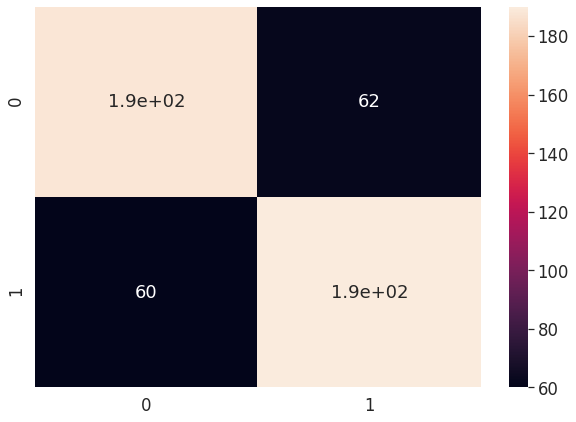

In [0]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(valid_tags, pred_tags)

df_cm = pd.DataFrame(conf_mat)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()


We can't look at accuracy with confidence. Indeed, our sample is really unbalanced and thus classifying all text as male would already give a 0.75 accuracy. This is exactly what happens here



In [0]:
import pandas as pd

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.
epoch,,,
1,0.561435,0.643202,0.768
2,0.444754,0.595550,0.758
3,0.314224,0.951572,0.776
4,0.179277,1.091080,0.762
5,0.073712,1.301599,0.756


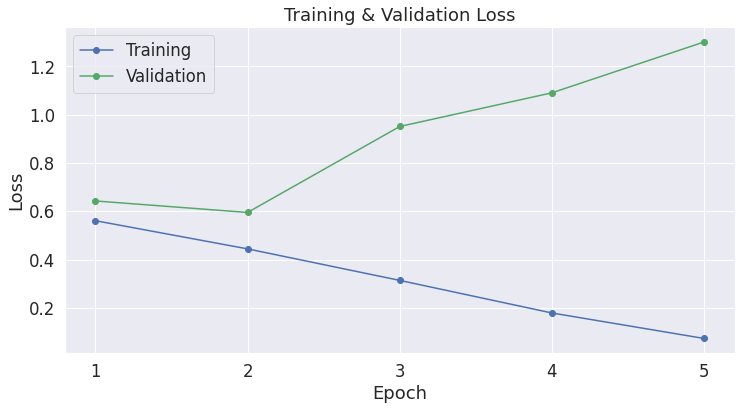

In [0]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5])

plt.show()

Our model is completely over fitting after 2 epochs !

RESTE A FAIRE A VOIR AVEC MELCHIOR 
- optimizer
- number of batch / sample / epochs 
- change criterion 
- accuracy replace with F1 score
- plot predictions and graph 
- improve loop ? 
- Make evaluation on a test set


In [0]:
@article{Wolf2019HuggingFacesTS,
  title={HuggingFace's Transformers: State-of-the-art Natural Language Processing},
  author={Thomas Wolf and Lysandre Debut and Victor Sanh and Julien Chaumond and Clement Delangue and Anthony Moi and Pierric Cistac and Tim Rault and R'emi Louf and Morgan Funtowicz and Jamie Brew},
  journal={ArXiv},
  year={2019},
  volume={abs/1910.03771}
}

SyntaxError: ignored